In [4]:
import pandas as pd
import numpy as np
import random

In [5]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="cuml")
warnings.filterwarnings("ignore", category=UserWarning, module="conda")



## Importando Dataset

Basta escolher o metodo referente ao dataset e tirar o comentário

In [6]:
from LoadDataset import LoadDataset


# data,target = LoadDataset.load_adult()

# data = data.iloc[:, random.sample(range(0, data.shape[1]), 3)]


# data = data.astype(np.float32)

data = pd.read_csv(

/opt/conda/lib/python3.12/site-packages/LoadDataset/LoadDataset.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.data.features[col] = le.fit_transform(adult.data.features[col])
/opt/conda/lib/python3.12/site-packages/LoadDataset/LoadDataset.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult.data.features[col] = le.fit_transform(adult.data.features[col])
/opt/conda/lib/python3.12/site-packages/LoadDataset/LoadDataset.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy o

## Rodar Random Forest

In [7]:
def run_random_forest_mg(new_data, target, _n_estimators, _max_depth, debug=False):
    import numpy as np
    import sklearn
    from sklearn import model_selection
    
    import pandas as pd
    import cudf
    import cuml
    import time
    import gc
    
    from cuml import datasets
    from cuml.model_selection import train_test_split
    from cuml.metrics import accuracy_score
    from cuml.dask.common import utils as dask_utils
    from dask.distributed import Client, wait
    from dask_cuda import LocalCUDACluster
    import dask_cudf
    import dask
    
    from cuml.dask.ensemble import RandomForestClassifier as cumlDaskRF

    # Check if there is already a Dask client running
    if not dask.config.get("distributed.client"):
        # This will use all GPUs on the local host by default
        cluster = LocalCUDACluster(threads_per_worker=1)
        c = Client(cluster)
        
        # Query the client for all connected workers
        workers = c.has_what().keys()
        n_workers = len(workers)
        n_streams = 8  # Performance optimization
        
        if debug: print(f"Created a new cluster with {n_workers} workers and {n_streams} streams.")
    else:
        c = Client()  # Use the existing client if available
        workers = c.has_what().keys()
        n_workers = len(workers)
        n_streams = 8  # Performance optimization
        
        if debug: print(f"Using existing cluster with {n_workers} workers and {n_streams} streams.")

    if debug:
        print(f'N workers: {n_workers}')

    if n_workers > _n_estimators:
        _n_estimators = n_workers

    # Converter os dados para um DataFrame do cudf
    X_cudf = new_data
    y_cudf = cudf.Series(target)

    X_cudf = X_cudf.astype(np.float32)
    y_cudf = y_cudf.astype(np.int32)

    
    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X_cudf, y_cudf, test_size=0.2, random_state=42)

    n_partitions = n_workers

    def distribute(X, y):
        # First convert to cudf (with real data, you would likely load in cuDF format to start)
        X_cudf = cudf.DataFrame(X)
        y_cudf = cudf.Series(y)
    
        # Partition with Dask
        # In this case, each worker will train on 1/n_partitions fraction of the data
        X_dask = dask_cudf.from_cudf(X_cudf, npartitions=n_partitions)
        y_dask = dask_cudf.from_cudf(y_cudf, npartitions=n_partitions)
    
        # Persist to cache the data in active memory
        X_dask, y_dask = \
          dask_utils.persist_across_workers(c, [X_dask, y_dask], workers=workers)
        
        return X_dask, y_dask
    
    X_train_dask, y_train_dask = distribute(X_train, y_train)
    X_test_dask, y_test_dask = distribute(X_test, y_test)

    rf = cumlDaskRF(max_depth=_max_depth, n_estimators=_n_estimators,
                    n_streams=n_streams)

    start_time = time.time()
    rf.fit(X_train_dask, y_train_dask)
    end_time = time.time()

    wait(rf.rfs) # Allow asynchronous training tasks to finish
    
    if debug:
        print(f'Tempo de treinamento do modelo RandomForest {_n_estimators},{_max_depth}: {end_time - start_time} segundos')
    
    # Fazer previsões no conjunto de teste
    y_pred = rf.predict(X_test_dask).compute().to_numpy()
    
    # del X_train, X_test, y_train, X_cudf, y_cudf
    # gc.collect()
    
    # Calcular a acurácia
    accuracy = accuracy_score(y_test, y_pred)
    if debug:
        print(f'Acurácia do modelo RandomForest {_n_estimators},{_max_depth}: {accuracy}')

    # # Limpar a memória da GPU
    # del y_test, y_pred
    # gc.collect()
    
    return accuracy, rf

In [12]:
def run_random_forest(new_data, target, _n_estimators, _max_depth, debug=False):
      from cuml.ensemble import RandomForestClassifier
      from cuml.metrics import accuracy_score
      from cuml.model_selection import train_test_split
      import cudf
      import time
      import gc


      # Converter os dados para um DataFrame do cudf
      X_cudf = new_data
      y_cudf = cudf.Series(target)

      # Dividir os dados em conjuntos de treinamento e teste
      X_train, X_test, y_train, y_test = train_test_split(X_cudf, y_cudf, test_size=0.2, random_state=42)


      # Instanciar e treinar o modelo RandomForest
      rf = RandomForestClassifier(n_estimators=_n_estimators,
                                  max_depth = _max_depth,
                                  random_state=42)

      start_time = time.time()
      rf.fit(X_train, y_train)
      end_time = time.time()

      if debug:
        print(f'Tempo de treinamento do modelo RandomForest {_n_estimators},{_max_depth}: {end_time - start_time} segundos')

      # Fazer previsões no conjunto de teste
      y_pred = rf.predict(X_test)

      # del X_train, X_test, y_train, X_cudf, y_cudf
      # gc.collect()

      # Calcular a acurácia
      accuracy = accuracy_score(y_test, y_pred)
      if debug:
        print(f'Acurácia do modelo RandomForest {_n_estimators},{_max_depth}: {accuracy}')

      # # Limpar a memória da GPU
      # del y_test, y_pred
      # gc.collect()

      return accuracy, rf, y_pred

In [18]:
import cudf

data = cudf.DataFrame(data)
acc, rf, y_pred = run_random_forest(data,target, 3,3,debug=True)

print(y_pred)


Tempo de treinamento do modelo RandomForest 3,3: 0.010459661483764648 segundos
Acurácia do modelo RandomForest 3,3: 0.5229320526123047
36865    1
21859    0
33148    0
14759    0
17144    0
        ..
6507     0
20707    0
7661     0
43985    0
37080    1
Length: 9768, dtype: int64


In [10]:
import cudf
import numpy as np
from tqdm import tqdm

# Convert the data to a cuDF DataFrame
data = cudf.DataFrame(data)

# Defining the values for N-trees and depth
n_trees = np.arange(8, 105, 5)  # From 5 to 100, multiples of 5
depth = np.arange(8, 105, 5)    # From 5 to 100, multiples of 5

accs = []

# Outer loop for n_trees with tqdm for progress bar
with tqdm(total=len(n_trees) * len(depth), desc="Processing RF") as pbar:
    for n in n_trees:
        for d in depth:
            acc, rf = run_random_forest(data, target, n, d, debug=False)
            accs.append((n, d, acc))
            # Update the progress bar and display the current iteration details
            pbar.set_postfix({'N-trees': n, 'Depth': d, 'Accuracy': f"{acc:.4f}"})
            pbar.update(1)



rocessing RF: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [03:13<00:00,  2.06it/s, N-trees=103, Depth=103, Accuracy=0.5249]

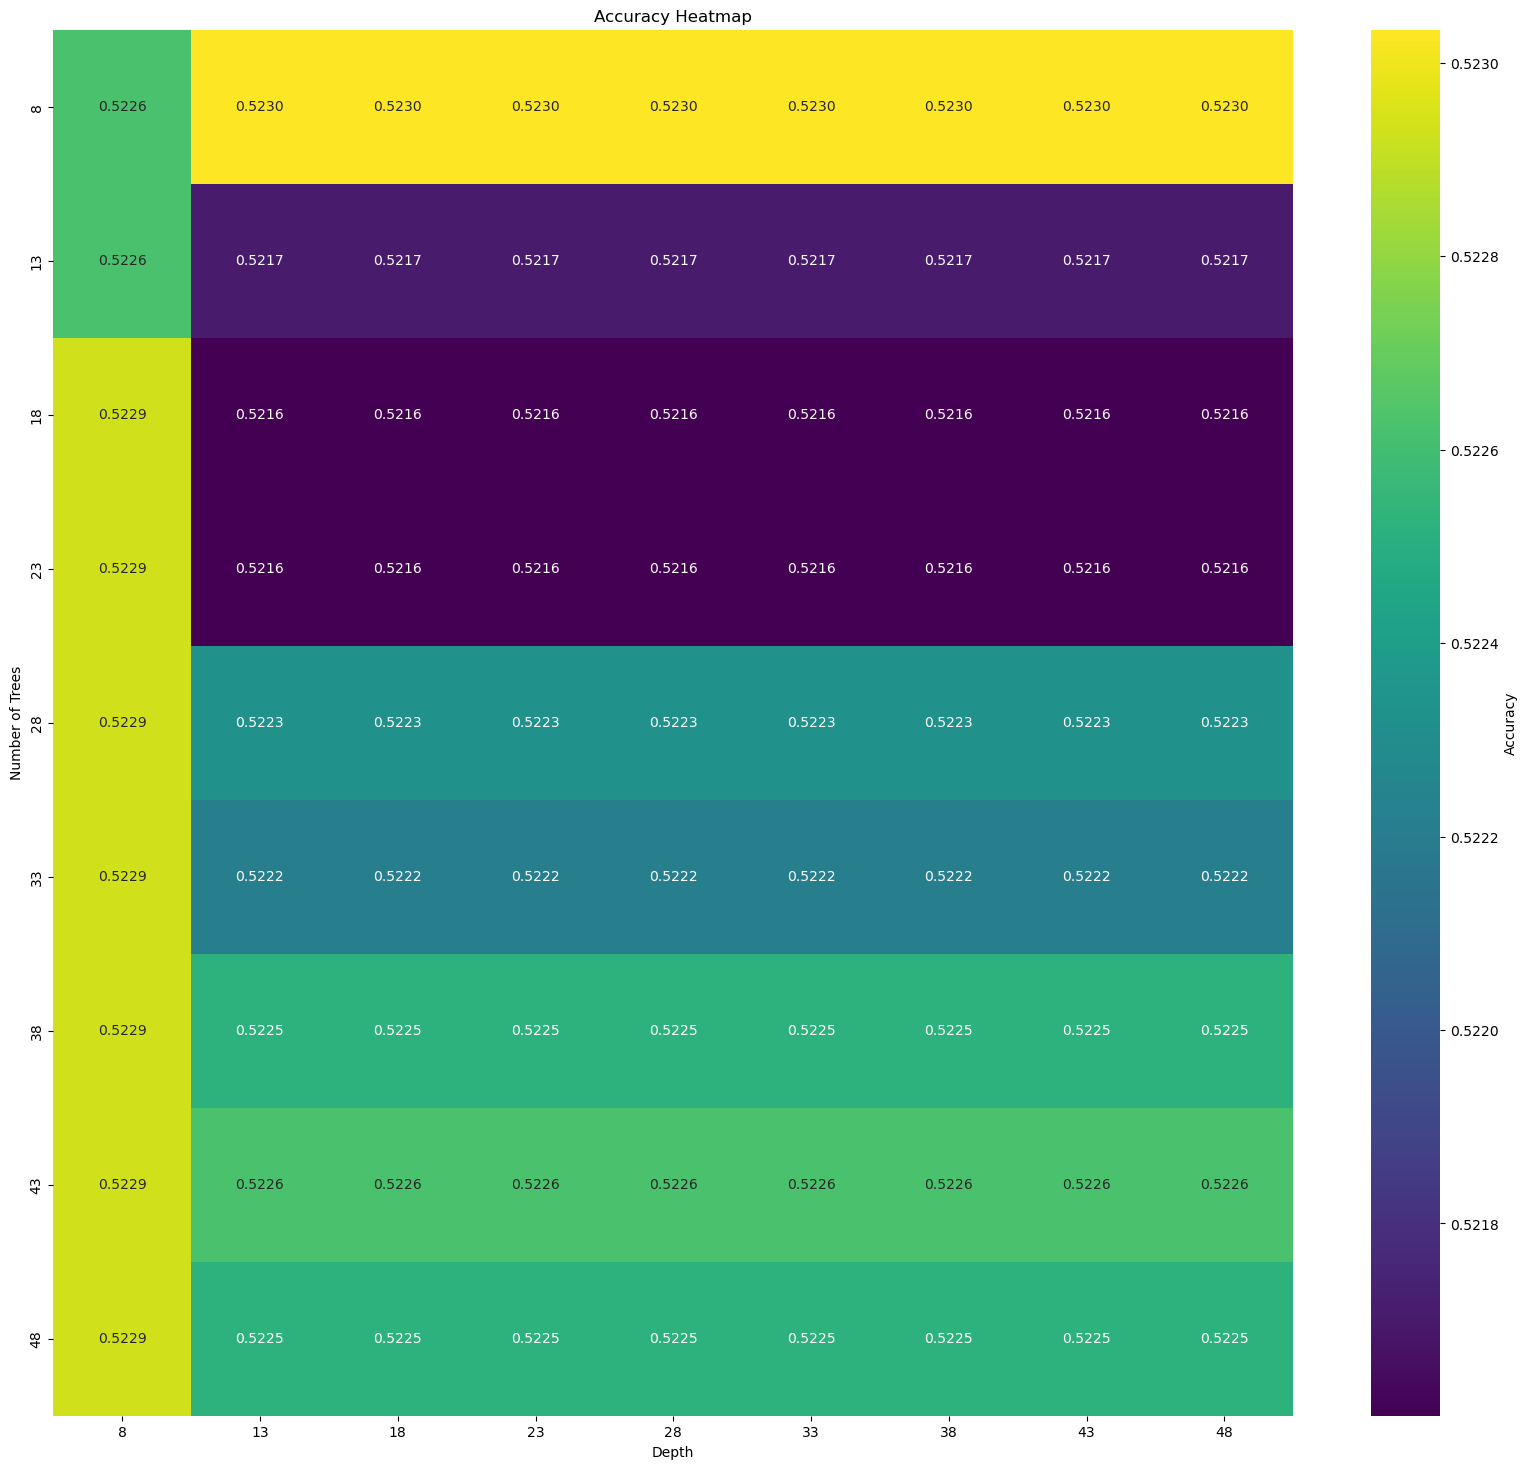

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the list to a DataFrame
graph = pd.DataFrame(accs, columns=['n_trees', 'depth', 'accuracy'])

graph = graph[
    (graph['n_trees'] >= 5) & (graph['n_trees'] <= 50) &
    (graph['depth'] >= 5) & (graph['depth'] <= 50)
]

# Pivot the DataFrame to create a matrix format suitable for a heatmap
heatmap_data = graph.pivot(index="n_trees", columns="depth", values="accuracy")

# Create the heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'Accuracy'})

# Add labels and title
plt.title("Accuracy Heatmap")
plt.xlabel("Depth")
plt.ylabel("Number of Trees")

# Save the heatmap to a file
plt.savefig("accuracy_heatmap_covtype.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
